In [205]:
from datetime import datetime
import re
import requests
import time

from matplotlib import dates as mpl_dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [206]:
def time_request_predict(host_url):
    start = time.time()
    r = requests.post(
        f'{host_url}/predict',
        json={
            "age": 34, 
            "fnlwgt": 261799, 
            "education_num": 11, 
            "capital_gain": 0, 
            "capital_loss": 0, 
            "hours_per_week": 56
        }
    )
    end = time.time()
    return r, end-start


def time_request(host_url):
    start = time.time()
    r = requests.get(host_url)
    end = time.time()
    return r, end-start

In [259]:
# r, response_time = time_request('https://wrchvs35n6.execute-api.us-east-1.amazonaws.com/lambda_flask_ml')
# r, response_time = time_request('https://yhju01gdah.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml_s3')
r, response_time = time_request('https://okxxo17i90.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml')
# r, response_time = time_request('http://127.0.0.1:5000')

print(r)
print(f"{int(response_time*1000):,} ms")

<Response [504]>
29,143 ms


In [ ]:
servers = {
    'zip': 'https://wrchvs35n6.execute-api.us-east-1.amazonaws.com/lambda_flask_ml',
    'docker_s3': 'https://yhju01gdah.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml_s3',
    'docker_disk': 'https://okxxo17i90.execute-api.us-east-1.amazonaws.com/lambda_docker_flask_ml'
}

while True:
    print(f"{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}: Beginning requests...")
    for server_name, server_url in servers.items():
        for x in range(0, 10):
            request_at = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            r, response_time = time_request_predict(server_url)
            with open('predict_performance.csv', 'a') as f_out:
                # server,request_at,response_time_ms,response_status_code
                f_out.write(f"{server_name},{request_at},{response_time*1000:0.2f},{r.status_code}\n")
    time.sleep(7*60)

# Analyze Locust Performance Tests

In [334]:
RUN_NAME = 'DOCKER_DISK_TEST_ROUND_5'
# RUN_NAME = 'DOCKER_S3_TEST_ROUND_15'

txt = open(f'locust_logs/{RUN_NAME}_locust_logs.txt').read()

data = [
    {
        'request_at': re.search('\[(.*)\]',line).group(1),
        'response_time_ms': re.search('\s(\d{1,5}\.\d{2})$', line).group(1)
    } 
    for line in txt.split('\n') if '/root' in line
]

In [335]:
df = pd.DataFrame(data)
df['response_time_ms'] = df['response_time_ms'].astype(float)
df['request_at'] = pd.to_datetime(df['request_at'], format='%Y-%m-%d %H:%M:%S,%f')
df.sort_values('request_at').head()

,request_at,response_time_ms
0,2021-07-23 19:05:36.662,4739.58
1,2021-07-23 19:05:36.683,306.99
2,2021-07-23 19:05:36.700,273.53
3,2021-07-23 19:05:36.701,220.38
4,2021-07-23 19:05:36.711,179.90


In [336]:
df.response_time_ms.describe()

count     1077.000000
mean      1483.701309
std       5546.717782
min         42.440000
25%         61.740000
50%         96.760000
75%        128.610000
max      28749.290000
Name: response_time_ms, dtype: float64

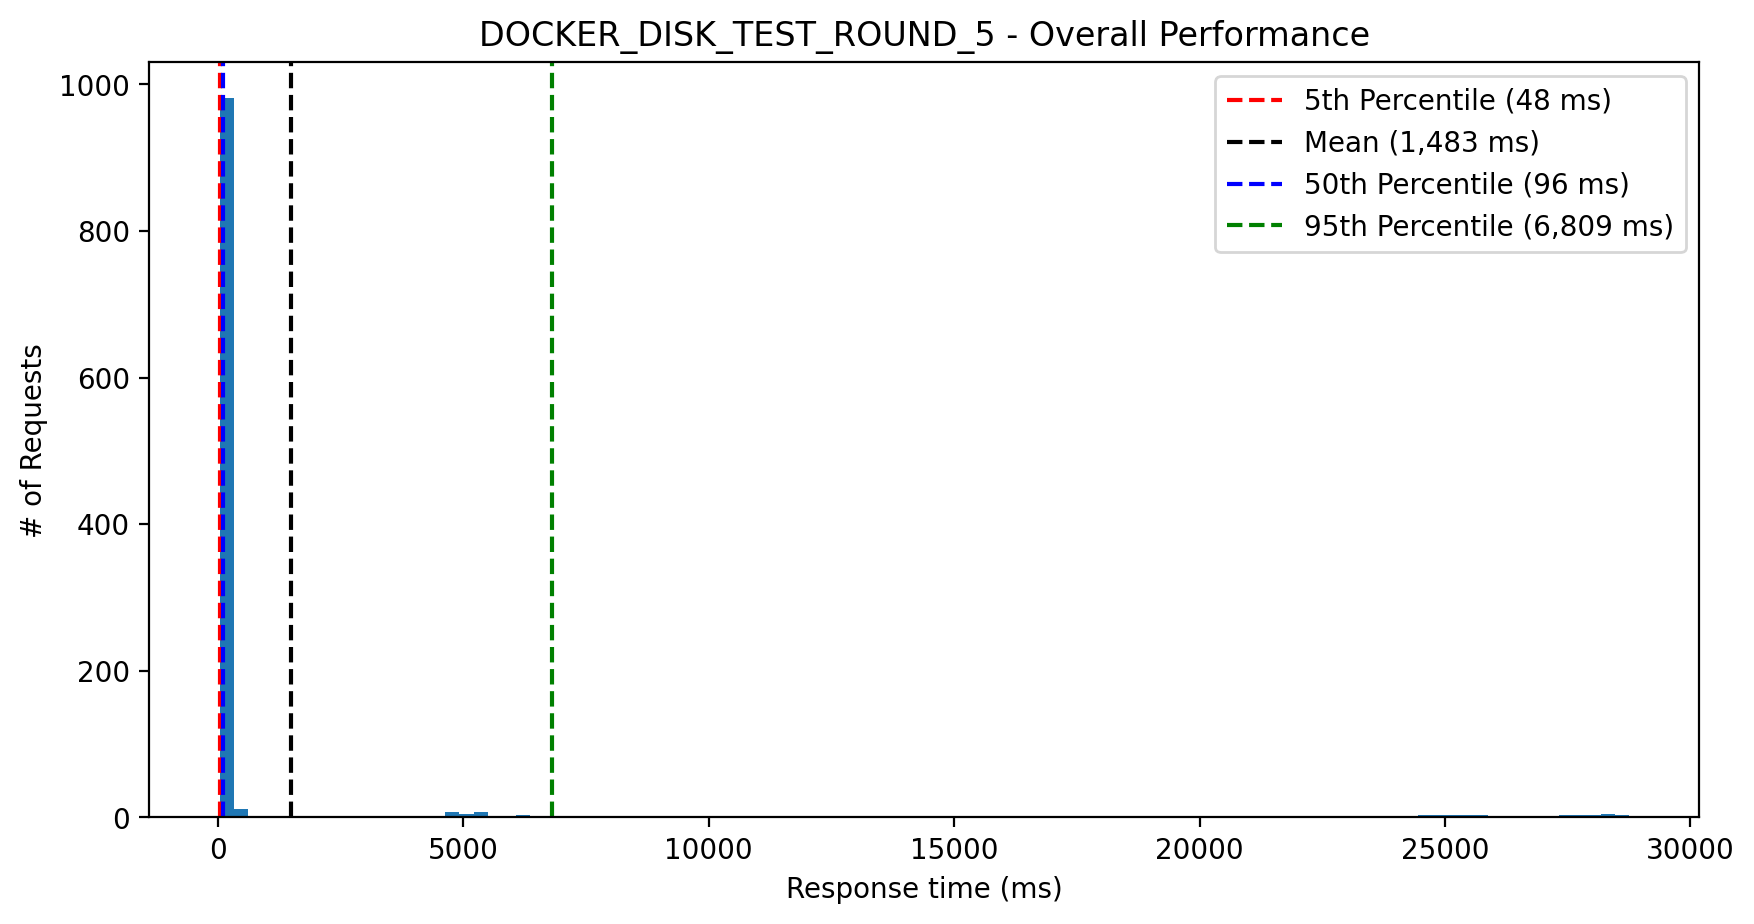

In [337]:
plt.figure(figsize=(10, 5), dpi=200)

p_95 = int(np.percentile(df.response_time_ms, 95))
p_05 = int(np.percentile(df.response_time_ms, 5))
p_50 = int(np.percentile(df.response_time_ms, 50))
mean = int(np.mean(df.response_time_ms))

plt.title(f"{RUN_NAME} - Overall Performance")
# plt.title(f"Overall Performance Distribution")
plt.hist(df.response_time_ms, bins=100);
plt.xlabel("Response time (ms)");
plt.ylabel("# of Requests");
plt.axvline(p_05, color='r', linestyle='dashed', label=f'5th Percentile ({p_05:,} ms)');
plt.axvline(mean, color='k', linestyle='dashed', label=f'Mean ({mean:,} ms)');
plt.axvline(p_50, color='b', linestyle='dashed', label=f'50th Percentile ({p_50:,} ms)');
plt.axvline(p_95, color='g', linestyle='dashed', label=f'95th Percentile ({p_95:,} ms)');
plt.legend();


# start_ts = df.request_at.min()
# end_ts = df.request_at.min()

# # first 15 seconds
# plt.hist(df[df.request_at <= (start_ts + pd.Timedelta(seconds=15))].response_time_ms, bins=50);

# # after 15 seconds
# plt.hist(df[df.request_at >= (start_ts + pd.Timedelta(seconds=15))].response_time_ms, bins=50);

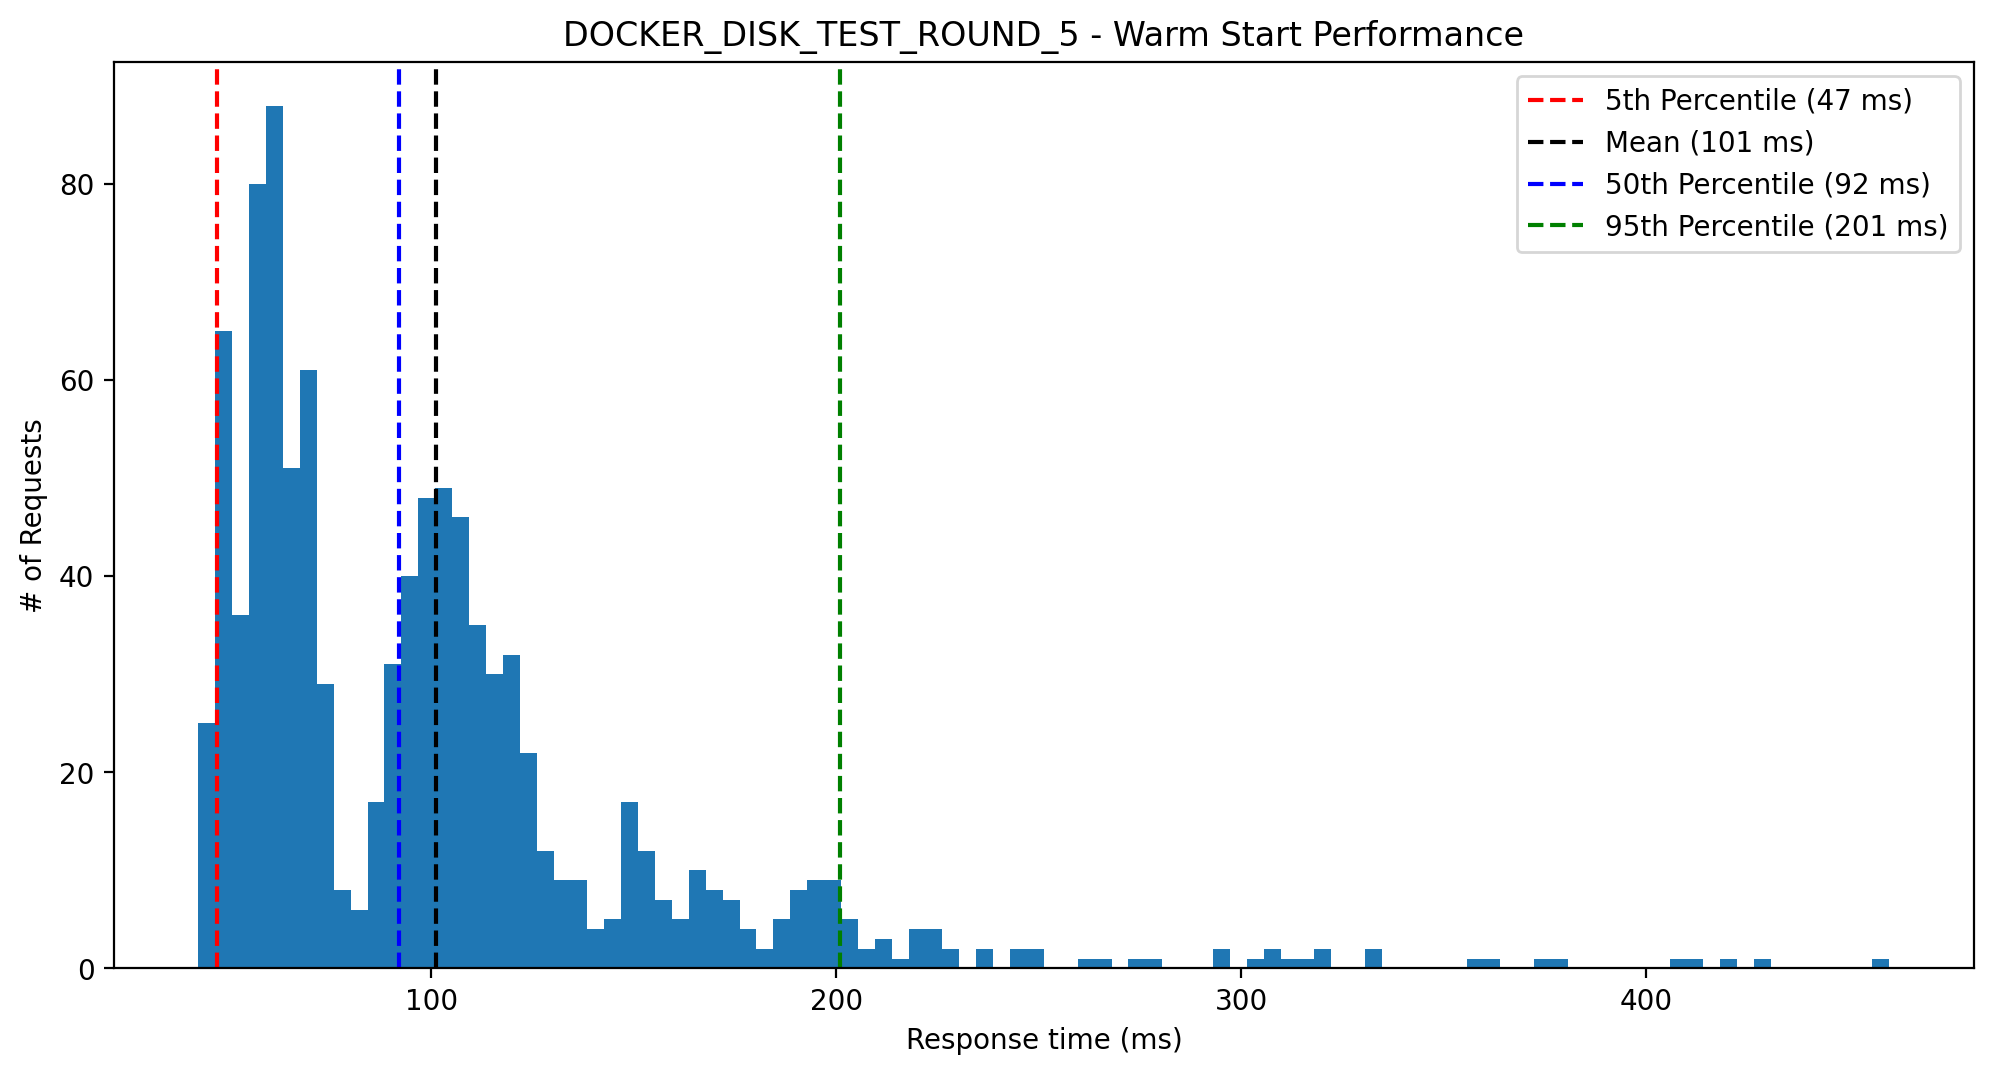

In [338]:
# warm starts
warm_starts = df[df.response_time_ms < 1000].response_time_ms

plt.figure(figsize=(12,6), dpi=200)

p_95 = int(np.percentile(warm_starts, 95))
p_05 = int(np.percentile(warm_starts, 5))
p_50 = int(np.percentile(warm_starts, 50))
mean = int(np.mean(warm_starts))

plt.title(f"{RUN_NAME} - Warm Start Performance")
plt.xlabel("Response time (ms)");
plt.ylabel("# of Requests");
plt.hist(warm_starts, bins=100);
plt.axvline(p_05, color='r', linestyle='dashed', label=f'5th Percentile ({p_05:,} ms)');
plt.axvline(mean, color='k', linestyle='dashed', label=f'Mean ({mean:,} ms)');
plt.axvline(p_50, color='b', linestyle='dashed', label=f'50th Percentile ({p_50:,} ms)');
plt.axvline(p_95, color='g', linestyle='dashed', label=f'95th Percentile ({p_95:,} ms)');
plt.legend();

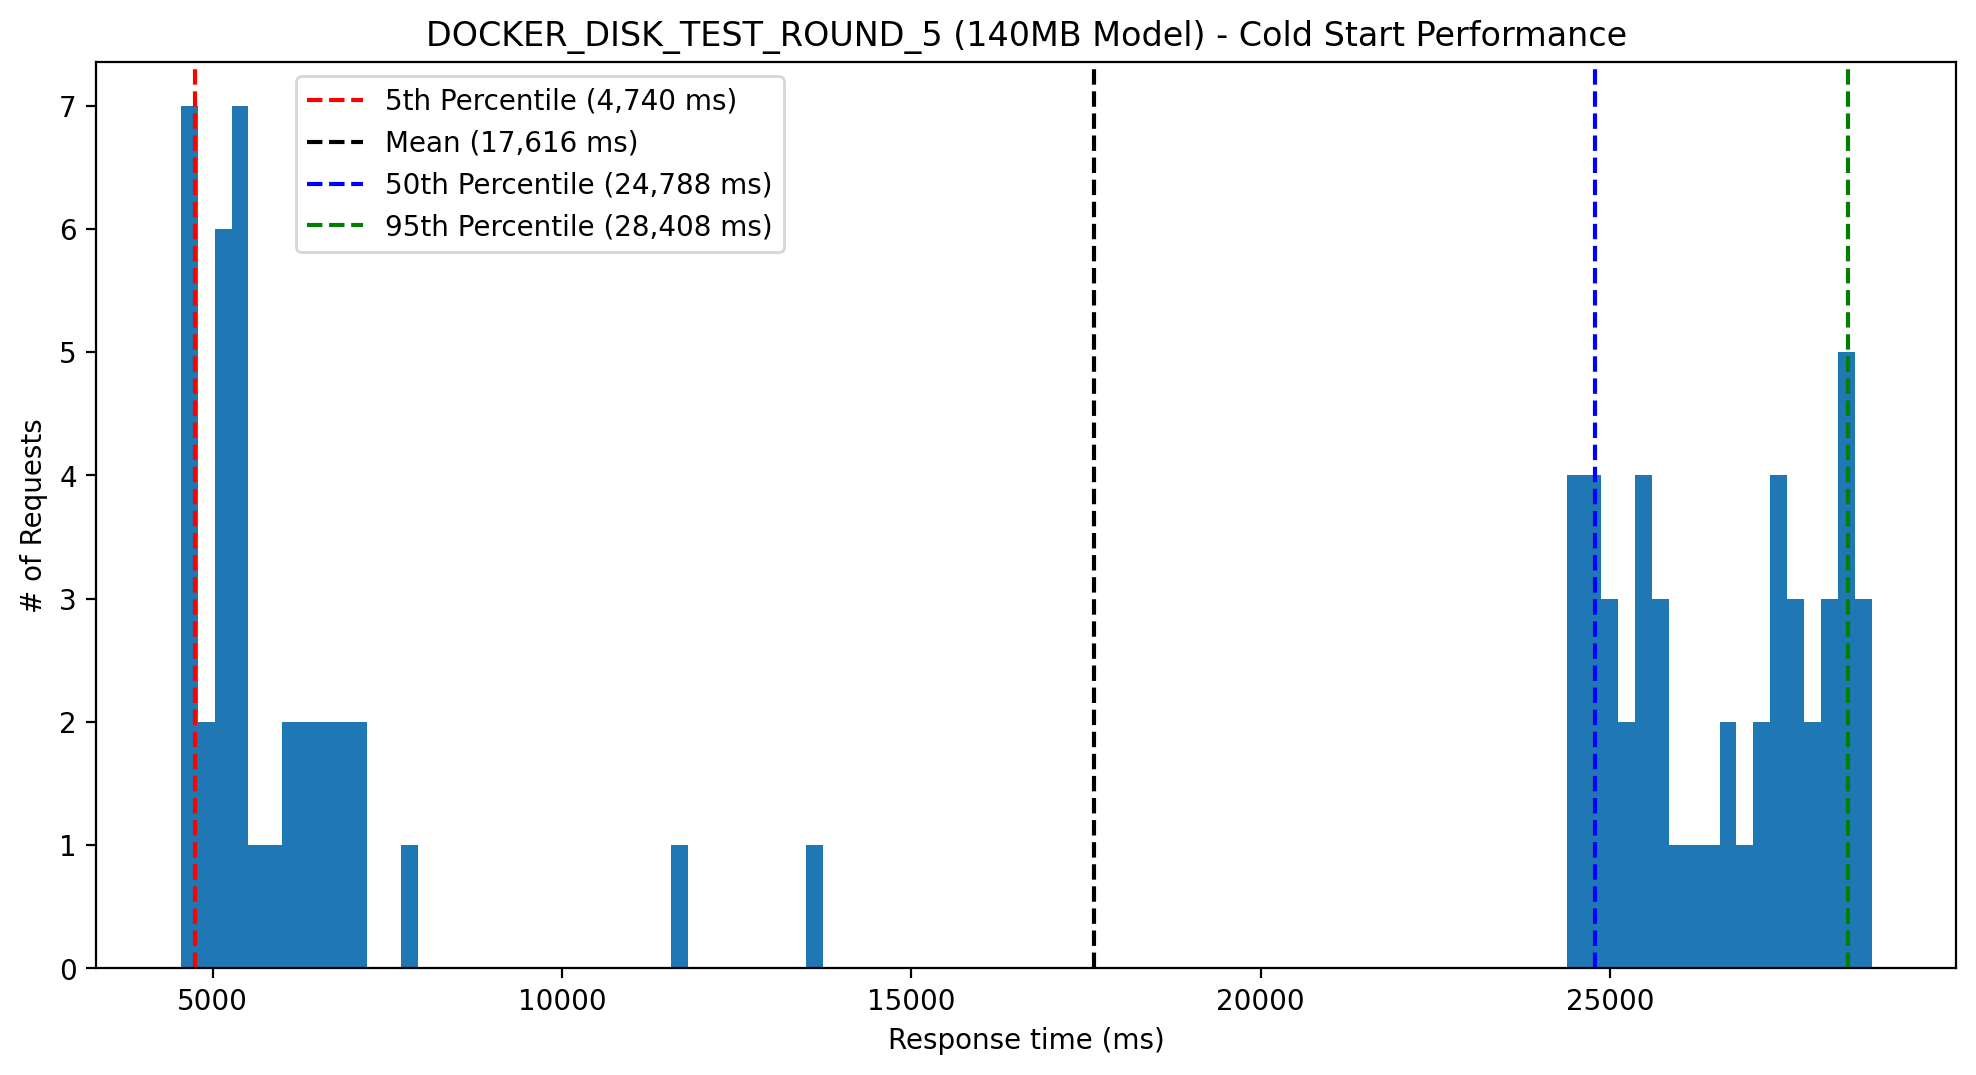

In [356]:
# cold starts
cold_starts = df[df.response_time_ms > 1000].response_time_ms

plt.figure(figsize=(12,6), dpi=200)

p_95 = int(np.percentile(cold_starts, 95))
p_05 = int(np.percentile(cold_starts, 5))
p_50 = int(np.percentile(cold_starts, 50))
mean = int(np.mean(cold_starts))

plt.title(f"{RUN_NAME} (140MB Model) - Cold Start Performance")
plt.xlabel("Response time (ms)");
plt.ylabel("# of Requests");
plt.hist(cold_starts, bins=100);
plt.axvline(p_05, color='r', linestyle='dashed', label=f'5th Percentile ({p_05:,} ms)');
plt.axvline(mean, color='k', linestyle='dashed', label=f'Mean ({mean:,} ms)');
plt.axvline(p_50, color='b', linestyle='dashed', label=f'50th Percentile ({p_50:,} ms)');
plt.axvline(p_95, color='g', linestyle='dashed', label=f'95th Percentile ({p_95:,} ms)');
plt.legend(loc='upper left', bbox_to_anchor=(0.1, 1));

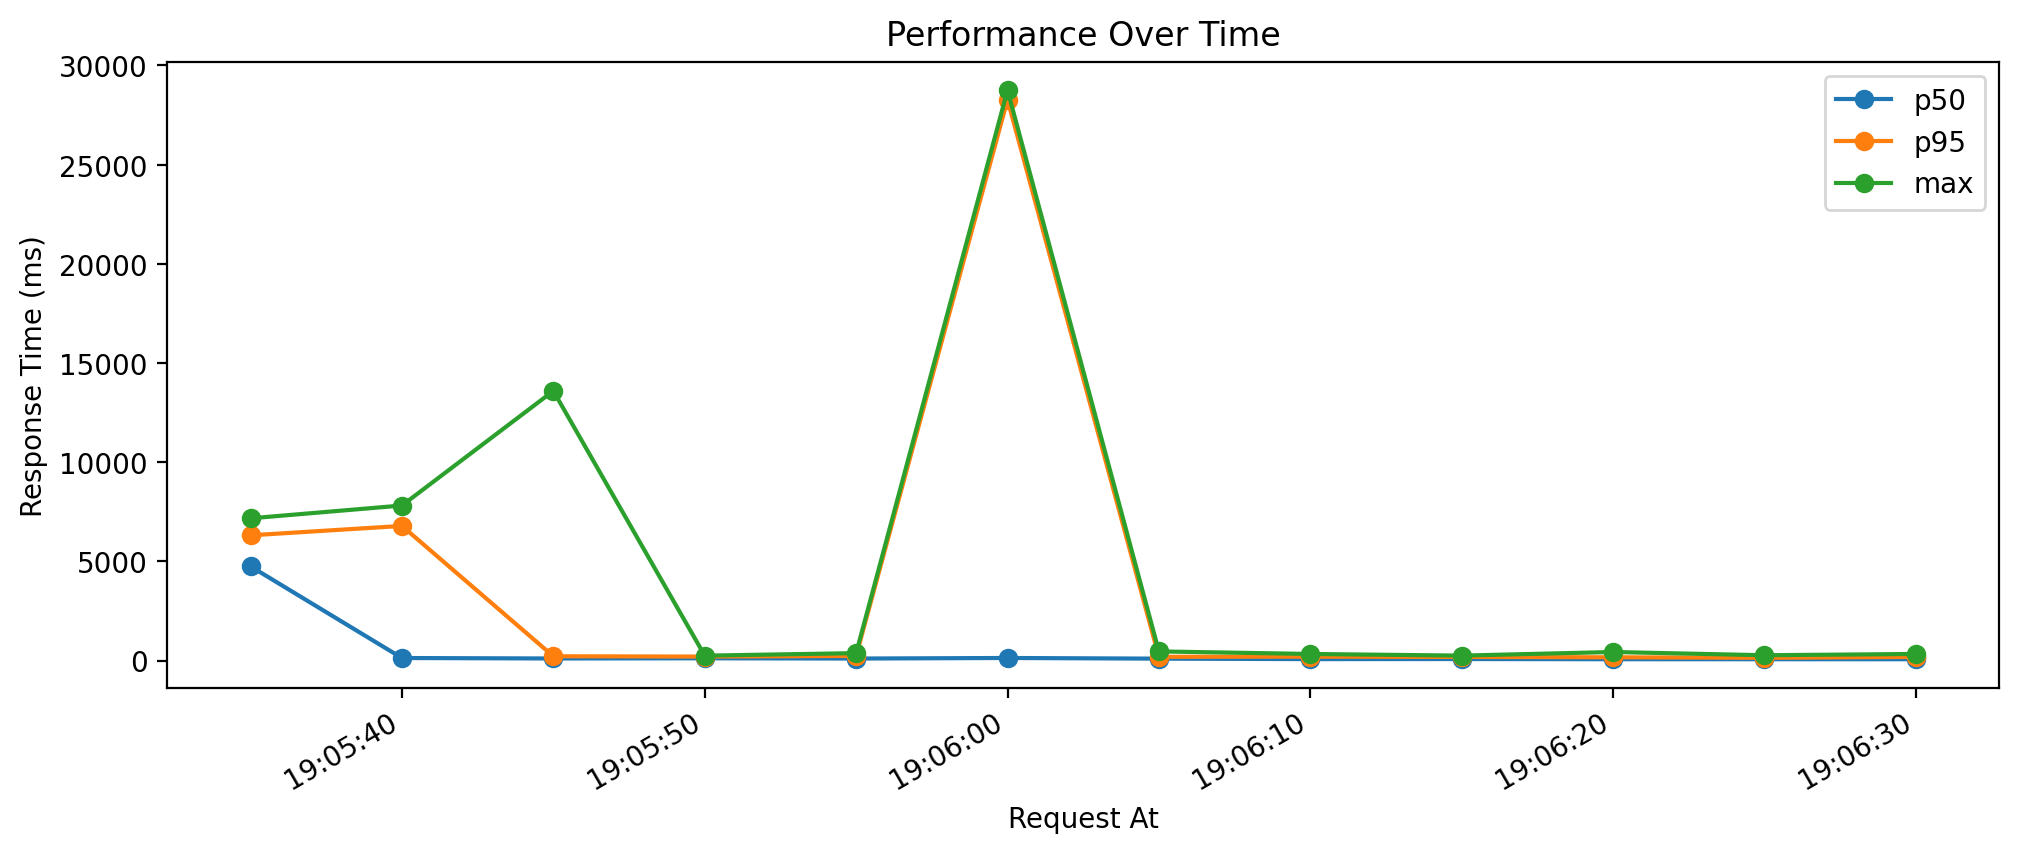

In [340]:
# https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
def percentile(n):
    def percentile_(x):
        if len(x) > 0:
            return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

start_ts = df.request_at.min()

summary = (
#     df[df.request_at >= (start_ts + pd.Timedelta(seconds=15))]
    df
    .groupby(pd.Grouper(key='request_at', freq='5S'))
    .response_time_ms
    .agg(
        p50=percentile(50),
        p95=percentile(95),
        max_rt='max',
    )
    .reset_index()
)

# summary
fig = plt.figure(figsize=(10, 4), dpi=200)


plt.plot_date(summary.request_at, summary.p50, linestyle='solid', label='p50')
plt.plot_date(summary.request_at, summary.p95, linestyle='solid', label='p95')
plt.plot_date(summary.request_at, summary.max_rt, linestyle='solid', label='max')
plt.legend()
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
# plt.title(f'{RUN_NAME} - Performance Over Time')
plt.title(f'Performance Over Time')
plt.xlabel('Request At')
plt.ylabel('Response Time (ms)')
plt.show()

# All Runs

In [317]:
data = []

for config_type in ['DOCKER_DISK', 'DOCKER_S3']:
    for test_round_num in range(1,25):
        RUN_NAME = f'{config_type}_TEST_ROUND_{test_round_num}'
        try:
            txt = open(f'locust_logs/{RUN_NAME}_locust_logs.txt').read()
        except:
            break
        if test_round_num < 8:
            model_size = '1. 140MB'
        elif test_round_num < 14:
            model_size = '2. 420MB'
        else:
            model_size = '3. 1090MB'
        data += [
            {
                'run_id': RUN_NAME,
                'config_type': config_type,
                'run_num': test_round_num,
                'model_size': model_size,
                'request_at': re.search('\[(.*)\]',line).group(1),
                'response_time_ms': re.search('\s(\d{1,5}\.\d{2})$', line).group(1)
            } 
            for line in txt.split('\n') if '/root' in line
        ]
df = pd.DataFrame(data)
df['response_time_ms'] = df['response_time_ms'].astype(float)
df['request_at'] = pd.to_datetime(df['request_at'], format='%Y-%m-%d %H:%M:%S,%f')
print(df.shape)
df.sort_values('request_at').head()

(40690, 6)


,run_id,config_type,run_num,model_size,request_at,response_time_ms
0,DOCKER_DISK_TEST_ROUND_1,DOCKER_DISK,1,1. 140MB,2021-07-18 19:16:16.750,4220.18
1,DOCKER_DISK_TEST_ROUND_1,DOCKER_DISK,1,1. 140MB,2021-07-18 19:16:16.881,5264.90
2,DOCKER_DISK_TEST_ROUND_1,DOCKER_DISK,1,1. 140MB,2021-07-18 19:16:16.881,484.57
3,DOCKER_DISK_TEST_ROUND_1,DOCKER_DISK,1,1. 140MB,2021-07-18 19:16:16.882,384.50
4,DOCKER_DISK_TEST_ROUND_1,DOCKER_DISK,1,1. 140MB,2021-07-18 19:16:16.882,330.84


In [319]:
summary = (
    df[df.response_time_ms > 1000]
    .groupby(['config_type', 'model_size'])
    .response_time_ms
    .agg(
        mean_response_time='mean',
        p25_response_time=percentile(25),
        p50_response_time=percentile(50),
        p75_response_time=percentile(75),
        p95_response_time=percentile(95),
        p99_response_time=percentile(99),
        max_response_time='max',
    )
    .reset_index()
)


float_cols = summary.select_dtypes(include=['float64'])
for col in summary.columns:
    if summary[col].dtype == 'float64':
        summary[col] = summary[col].astype('int64')
    
    summary.rename(columns={col: col.replace('_response_time', '')}, inplace=True)
    
out = summary.sort_values(['model_size', 'config_type'])
out

,config_type,model_size,mean,p25,p50,p75,p95,p99,max
0,DOCKER_DISK,1. 140MB,10629,5008,5572,8446,29161,29217,29326
3,DOCKER_S3,1. 140MB,7108,5260,5706,8679,13063,14394,14712
1,DOCKER_DISK,2. 420MB,9490,7800,8312,8907,29083,29181,29220
4,DOCKER_S3,2. 420MB,10765,9409,10096,11523,15232,16561,18787
2,DOCKER_DISK,3. 1090MB,19802,16289,17590,24765,29134,29197,29233
5,DOCKER_S3,3. 1090MB,20236,19310,20172,21038,23046,24052,29155


In [326]:
print(out.to_markdown())

|    | config_type   | model_size   |   mean |   p25 |   p50 |   p75 |   p95 |   p99 |   max |
|---:|:--------------|:-------------|-------:|------:|------:|------:|------:|------:|------:|
|  0 | DOCKER_DISK   | 1. 140MB     |  10629 |  5008 |  5572 |  8446 | 29161 | 29217 | 29326 |
|  3 | DOCKER_S3     | 1. 140MB     |   7108 |  5260 |  5706 |  8679 | 13063 | 14394 | 14712 |
|  1 | DOCKER_DISK   | 2. 420MB     |   9490 |  7800 |  8312 |  8907 | 29083 | 29181 | 29220 |
|  4 | DOCKER_S3     | 2. 420MB     |  10765 |  9409 | 10096 | 11523 | 15232 | 16561 | 18787 |
|  2 | DOCKER_DISK   | 3. 1090MB    |  19802 | 16289 | 17590 | 24765 | 29134 | 29197 | 29233 |
|  5 | DOCKER_S3     | 3. 1090MB    |  20236 | 19310 | 20172 | 21038 | 23046 | 24052 | 29155 |


In [324]:
import tabulate